In [1]:
import mmf_setup;mmf_setup.nbinit(hgroot=False)
from mmfutils.contexts import NoInterrupt
from mmfutils.plot import imcontourf
%pylab inline
import numpy as np

<IPython.core.display.Javascript object>

Populating the interactive namespace from numpy and matplotlib


In [2]:
def fft2(y):
    return np.fft.fftn(y, axes=(0,1))           
def ifft2(y):
    return np.fft.ifftn(y, axes=(0,1))
def f(x,y):
    return np.sin(x + y)

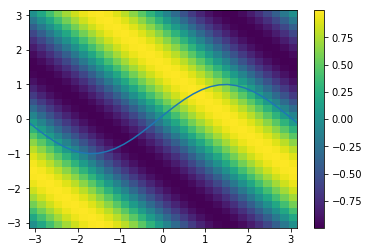

In [3]:
N = 32
L = 2*np.pi
dx = L/N
dy = dx
x = np.linspace(0,L,N) - L/2
y = np.linspace(0,L,N) - L/2
xx, yy = np.meshgrid(x, y, indexing='ij', sparse=True)
z = np.sin(xx + yy) # sin(x^2 + y^2)
imcontourf(x,y,z)
plt.plot(x,z[16])
plt.colorbar()
mat_shape = (N**2,)*2
Nxy = (N, N)
kxy = (2*np.pi * np.fft.fftfreq(N, dx)[:, None],
       2*np.pi * np.fft.fftfreq(N, dy)[None, :])
tensor_shape = (N,N,N,N)

In [4]:
nabla = np.eye(mat_shape[0]).reshape(tensor_shape)
K = np.eye(mat_shape[0]).reshape(tensor_shape)
D1 = ifft2(1j*sum(_k  for _k in kxy)[:, :,  None, None]
           *fft2(nabla)).reshape((np.prod(Nxy),)*2).reshape(mat_shape)
D2 = ifft2(sum(-_k**2 for _k in kxy)[:, :,  None, None]
           *fft2(K)).reshape((np.prod(Nxy),)*2).reshape(mat_shape)

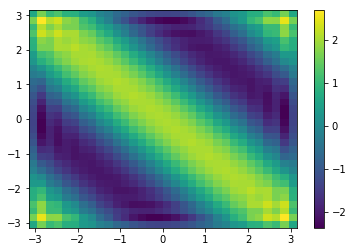

In [5]:
z1 = D1.dot(z.ravel()).reshape(N,N)
imcontourf(x,y,z1.real)
#plt.contourf(x, y, z1.real)
#plt.plot(x,z1[32])
plt.colorbar()

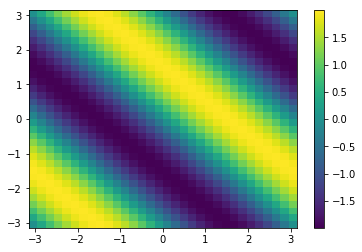

In [6]:
#z2 = (2*xx + 2 * yy) * np.cos(xx**2+yy**2)
z2 = 2*np.sin(xx+yy)#np.cos(xx)*np.cos(yy)-np.sin(xx)*np.sin(yy)# (2*yy+2*xx)* np.cos(xx**2+yy**2)
imcontourf(x,y,z2)
#plt.plot(x,z2[32])
plt.colorbar()

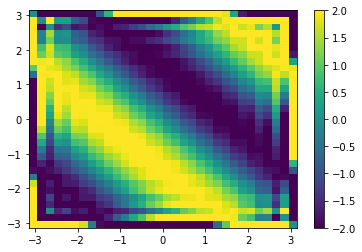

In [7]:
#z3 = D1.dot(z1.ravel()).reshape(N,N)
z3 = D2.dot(z.ravel()).reshape(N,N)
imcontourf(x,y,z3.real, vmin=-2.0, vmax=2.0)
#plt.plot(x,z1[32])
plt.colorbar()

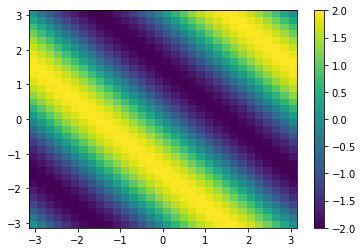

In [8]:
#z2 = (2*xx + 2 * yy) * np.cos(xx**2+yy**2)
z4 =-2*np.sin(xx+yy)#-2*(np.sin(xx)*np.cos(yy)+np.cos(xx)*np.sin(yy))#4*np.cos(xx**2 + yy**2) -4*(xx+yy)**2*np.sin(xx**2+yy**2)
imcontourf(x,y,z4, vmin=-2.0, vmax=2.0)
#plt.plot(x,z2[32])
plt.colorbar()

# MMF Notes

Here is how one computes the second derivative with the FFT.

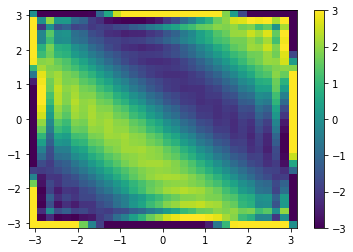

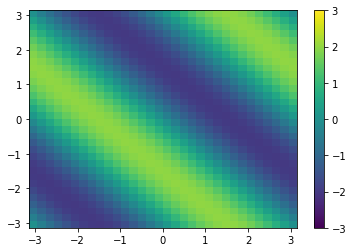

In [9]:
from mmfutils.plot import imcontourf
kx, ky = kxy
z = np.sin(xx+yy)
laplacian_z = np.fft.ifftn(-(kx**2+ky**2)*np.fft.fftn(z))

plt.figure()
imcontourf(x, y, laplacian_z.real, vmax=3, vmin=-3);plt.colorbar()

plt.figure()
imcontourf(x, y, -2*np.sin(xx+yy), vmax=3, vmin=-3);plt.colorbar()

## Test the modified kinetic density matrix

In [10]:
import numpy as np
from scipy.integrate import quad
from uncertainties import ufloat
from importlib import reload  # Python 3.4+
import numpy as np
import homogeneous;reload(homogeneous)
import vortex_2d_aslda;reload(vortex_2d_aslda)
hbar = 1
m = 1
N = 32
L = 6
mu_eff = 1.0
n = 1.0
e_F = 1.0
k_F = np.sqrt(2*m*e_F)
n_F = k_F**3/3/np.pi**2
E_FG = 2./3*n_F*e_F
mu = 0.59060550703283853378393810185221521748413488992993*e_F
delta = 0.68640205206984016444108204356564421137062514068346*e_F
grid_size = N
aslda = vortex_2d_aslda.ASLDA(Nxy=(grid_size,)*2)
k_c = abs(aslda.kxy[0]).max()
E_c = (aslda.hbar*k_c)**2/2/aslda.m
aslda = vortex_2d_aslda.ASLDA(Nxy=(grid_size,)*2, Lxy=(L,)*2, E_c=E_c)
dx = L/N
dy = dx
x = np.linspace(0,L,N) - L/2
y = np.linspace(0,L,N) - L/2
xx, yy = np.meshgrid(x, y, indexing='ij', sparse=True)

In [11]:
def get_D2(self, twist=(0,0)):
        kxy = self.kxy
        mat_shape = (np.prod(self.Nxy),)*2
        tensor_shape = self.Nxy + self.Nxy
        K = np.eye(mat_shape[0]).reshape(tensor_shape)
        D2 = self.ifft2(sum(-_k**2 for _k in self.kxy)[:, :,  None, None]*self.fft2(K)).reshape((np.prod(self.Nxy),)*2).reshape(mat_shape)
        return D2
def get_modified_K(self, D2,alpha):
        """"return a modified kinetic density  matrix"""
        A = np.diag(alpha.ravel())
        K = (D2.dot(A) - np.diag(D2.dot(alpha.ravel())) + A.dot(D2)) / 2
        return K
    

### Analytic Results

We use a simple functions

$$
\alpha =  sin(x + y) \\
\psi(x,y) = cos(x^2 + y^2)
$$
their first and second order derivatives are:
$$
\frac{\partial \alpha}{\partial x}=cos(x+y)\\
\frac{\partial \alpha}{\partial y}=cos(x+y)\\
\frac{\partial \psi}{\partial x}=-2 x .sin(x^2+y^2)\\
\frac{\partial \psi}{\partial y}=-2 y .sin(x^2+y^2)\\
\frac{\partial^2 \psi}{\partial x^2}=-2 .sin(x^2+y^2) -4x^2cos(x^2 + y^2)\\
\frac{\partial^2 \psi}{\partial y^2}=-2 .sin(x^2+y^2) -4y^2cos(x^2 + y^2)\\
$$

The relation we use is:
\begin{align}
(\alpha \psi')'&=\alpha'\psi' + \alpha \psi'' \\
(\alpha \psi)''&=(\alpha'\psi+\alpha\psi')'\\
&=(\alpha''\psi+\alpha\psi''+2\alpha'\psi')\\
\alpha'\psi'&=\frac{(\alpha\psi)'' -\alpha''\psi-\alpha\psi''}{2}\\
so\\
(\alpha\psi')'&=\frac{(\alpha\psi)''-\alpha''\psi+\alpha\psi''}{2}
\end{align}

In the follow code, I use letter 'a' instead of $\alpha$

In [12]:
a = np.sin(xx+yy) #np.ones((N,N)) #
da_x =  np.cos(xx+yy) #0
da_y = da_x #0

In [13]:
f = np.cos(xx**2 + yy**2)
df_x = -2 * xx * np.sin(xx**2 + yy**2)
df_y = -2 * yy * np.sin(xx**2 + yy**2)
df_xx = -2 * np.sin(xx**2 + yy**2) -4 * xx**2 * np.cos(xx**2 + yy**2)
df_yy = -2 * np.sin(xx**2 + yy**2) -4 * yy**2 * np.cos(xx**2 + yy**2)

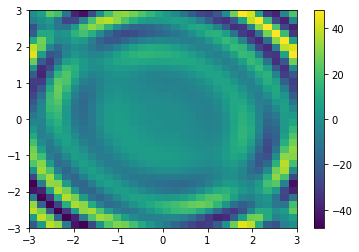

In [14]:
z = (da_x * df_x + da_y * df_y) + a * (df_xx + df_yy)
imcontourf(x,y,z)
plt.colorbar()

### Numerical Results

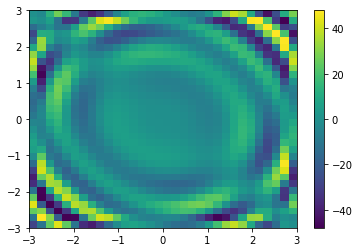

In [15]:
D2 = aslda.get_D2()
K = aslda.get_modified_K(D2=D2, alpha=a)
z1 = K.dot(f.ravel()).reshape((N,N))
imcontourf(x,y,z1.real, vmax=z.max(), vmin=z.min())
plt.colorbar()

It seems there is a factor off?

To figure out the problem, we set a = 1, and then D2 = K, I get what is expected: the results are unchanged. But if I compare that to the results directly to the D2_(as follow), I comfirm again the D2_ works correctly, so the D2 should have some problem, the code for D2 and D2_ are the same, with the help of debugging, I find the Kxy for D2 is different from D2_, and a bit trace back, the problem is that when I create ASLDA object, the Lxy did not set to the $2\pi$.

In [16]:
mat_shape = (N**2,)*2
Nxy = (N, N)
kxy = (2*np.pi * np.fft.fftfreq(N, dx)[:, None],
       2*np.pi * np.fft.fftfreq(N, dy)[None, :])
tensor_shape = (N,N,N,N)
K_ = np.eye(mat_shape[0]).reshape(tensor_shape)
D2_ = ifft2(sum(-_k**2 for _k in kxy)[:, :,  None, None]
           *fft2(K_)).reshape((np.prod(Nxy),)*2).reshape(mat_shape)

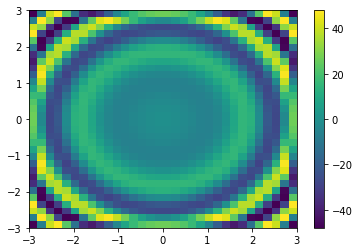

In [17]:
z3 = D2_.dot(f.ravel()).reshape((N,N))
imcontourf(x,y,z3.real, vmax=z.max(), vmin=z.min())
plt.colorbar()

In [18]:
dx,np.pi * 2 / 32

(0.1875, 0.19634954084936207)